# Photometric Redshift Estimation for Quasars using Deep Learning

### Authors: 
Thara Rubi Caba Pineda 

### Course:
Big Data in Space Science

### Professor:
Prof L.Č. Popović

### Assistant:  
Djordje Savic (Postdoc) 



## 1. Introduction

In this project, I aim to estimate the photometric redshift of quasars using photometric features such as magnitudes and colors. Photometric redshifts are crucial in large-scale astronomical surveys, as they provide estimates of redshift without requiring expensive and time-consuming spectroscopy.

Photometric redshift is an estimate of the redshift of a celestial object (such as a galaxy or quasar) based on its observed photometric properties, such as its brightness in different wavelength bands (e.g., the u, g, r, i, z bands used in the Sloan Digital Sky Survey or SDSS). It is inferred using data from images taken through a small number of broad filters, rather than from detailed spectroscopic measurements.

Using a deep neural network (DNN) model, I train on photometric data and test the performance of the model in predicting redshifts. Several machine learning techniques, including cross-validation, batch normalization, dropout, and regularization, are applied to improve the model's accuracy and generalization.

The primary objective of this work is to develop a model capable of accurately estimating photometric redshifts and evaluate its performance using various metrics and visualizations.

In [1]:
## commonly used modules
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys

from sklearn import preprocessing
from sklearn import model_selection
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

pd.set_option('display.max_columns', 1000)

2024-10-26 12:54:39.763229: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 2. Methods

### Data Loading and Preprocessing

I used the dataset of quasars Stripe82 Object Table from the LSST AGN Data Challenge, where the features include photometric magnitudes in different bands and colors. The target variable is the spectroscopic redshift (`z`), which we aim to predict using a deep learning model.

#### Selected Features
The following features were used for the photometric redshift estimation:
- psMag_*: Photometric magnitudes in different bands
- bdMag_*: Broadband magnitudes
- stdColor_*: Color indices


In [2]:
# Data directory setup
data_dir = "/Users/tharacaba/Desktop/Big_data"

# Load the dataset
object_df = pd.read_parquet(os.path.join(data_dir, 's82ObjectTable.parquet'))

In [3]:
# Define the attribute list for features
attr_list = [
    'psMag_u', 'psMag_g', 'psMag_r', 'psMag_i', 'psMag_z', 'psMag_y',
    'bdMag_u', 'bdMag_g', 'bdMag_r', 'bdMag_i', 'bdMag_z', 'bdMag_y',
    'stdColor_0', 'stdColor_1', 'stdColor_2', 'stdColor_3', 'stdColor_4',
    'class', 'photoZ_pest', 'z'
]

In [4]:
# Selecting QSOs
obj_df = object_df[attr_list].dropna()
qso_df = obj_df[obj_df['class'] == 'Qso']
display(qso_df.columns, qso_df.shape)

Index(['psMag_u', 'psMag_g', 'psMag_r', 'psMag_i', 'psMag_z', 'psMag_y',
       'bdMag_u', 'bdMag_g', 'bdMag_r', 'bdMag_i', 'bdMag_z', 'bdMag_y',
       'stdColor_0', 'stdColor_1', 'stdColor_2', 'stdColor_3', 'stdColor_4',
       'class', 'photoZ_pest', 'z'],
      dtype='object')

(3979, 20)

array([[<Axes: title={'center': 'psMag_u'}>,
        <Axes: title={'center': 'psMag_g'}>,
        <Axes: title={'center': 'psMag_r'}>,
        <Axes: title={'center': 'psMag_i'}>],
       [<Axes: title={'center': 'psMag_z'}>,
        <Axes: title={'center': 'psMag_y'}>,
        <Axes: title={'center': 'bdMag_u'}>,
        <Axes: title={'center': 'bdMag_g'}>],
       [<Axes: title={'center': 'bdMag_r'}>,
        <Axes: title={'center': 'bdMag_i'}>,
        <Axes: title={'center': 'bdMag_z'}>,
        <Axes: title={'center': 'bdMag_y'}>],
       [<Axes: title={'center': 'stdColor_0'}>,
        <Axes: title={'center': 'stdColor_1'}>,
        <Axes: title={'center': 'stdColor_2'}>,
        <Axes: title={'center': 'stdColor_3'}>],
       [<Axes: title={'center': 'stdColor_4'}>,
        <Axes: title={'center': 'photoZ_pest'}>,
        <Axes: title={'center': 'z'}>, <Axes: >]], dtype=object)

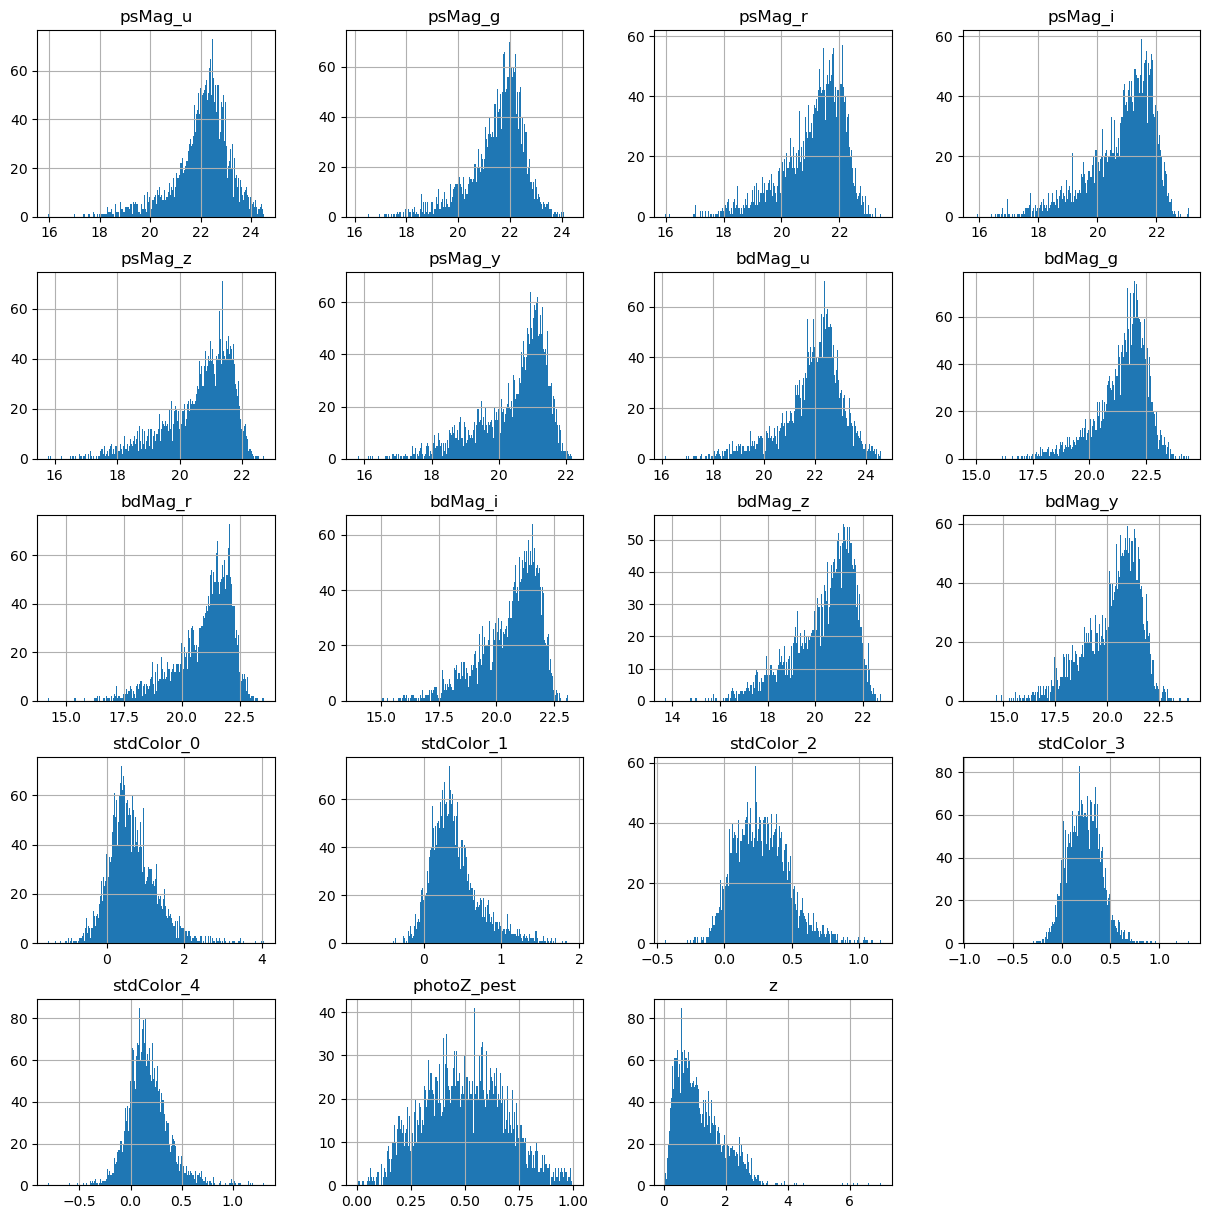

In [5]:
# Visualizing distribution of attributes
qso_df.hist(figsize=[15, 15], bins=300)

In [6]:
# Target and Features setup
y_df = qso_df[['z', 'photoZ_pest']]
X_df = qso_df.drop(['z', 'class', 'photoZ_pest'], axis=1)
print(X_df.shape, y_df.shape)
display(X_df.columns)

(3979, 17) (3979, 2)


Index(['psMag_u', 'psMag_g', 'psMag_r', 'psMag_i', 'psMag_z', 'psMag_y',
       'bdMag_u', 'bdMag_g', 'bdMag_r', 'bdMag_i', 'bdMag_z', 'bdMag_y',
       'stdColor_0', 'stdColor_1', 'stdColor_2', 'stdColor_3', 'stdColor_4'],
      dtype='object')

In [7]:
# Train-test split
X = X_df
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y_df, test_size=0.5, random_state=10)

In [8]:
# Standardization using StandardScaler
scalerX = preprocessing.StandardScaler()
X_train = scalerX.fit_transform(X_train)
X_test = scalerX.transform(X_test)

In [9]:
# Normalizing target (redshift)
scalerY = preprocessing.StandardScaler()
y_train = scalerY.fit_transform(y_train[['z']])
y_test = scalerY.transform(y_test[['z']])

### Model Architecture

The deep neural network (DNN) consists of multiple layers:
- Input layer: Corresponding to the number of selected features.
- Hidden layers: Several hidden layers with ReLU activations, batch normalization, and dropout to prevent overfitting.
- Output layer: A single neuron with linear activation to predict the continuous target (redshift).

Regularization is applied using L2 regularization and dropout layers to further improve generalization.

I applied a 5-fold cross-validation strategy to evaluate the model's performance on different subsets of the data. A learning rate scheduler was employed to dynamically adjust the learning rate, and early stopping was used to prevent overfitting during training.

In [10]:
# Define the model architecture
n_input_layer = X_train.shape[1]
n_middle_layer = int(2/3 * n_input_layer) + 1
n_output_layer = 1  # One output for regression

**Batch Normalization** is a technique used in deep learning to make training faster and more stable. It normalizes the inputs to each layer in the neural network by re-centering and re-scaling them during training. This helps in keeping the data within a certain range, preventing large shifts in the distribution of layer activations, known as internal covariate shift. By reducing these shifts, the network can learn more efficiently, converge faster, and become less sensitive to the choice of initial weights and learning rate.

**Dropout** is a regularization technique used to prevent overfitting in neural networks by randomly "dropping out" (i.e., deactivating) a fraction of neurons during training. At each training step, some neurons are randomly set to zero, which forces the network to learn more robust and distributed feature representations. This helps prevent the model from becoming too dependent on specific neurons, improving generalization to unseen data.

In [11]:
# Improved model with batch normalization and dropout
model = tf.keras.Sequential([
    tf.keras.layers.Input(n_input_layer),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(n_input_layer, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(150, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(n_middle_layer, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dense(n_output_layer, activation='linear')  # Linear activation for regression
])

2024-10-26 12:58:41.511504: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
# Learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3 * 10 ** (epoch / 30))

In [13]:
# Early stopping and checkpoint
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

In [14]:
# Compiling the model with Huber loss
model.compile(optimizer='adam',
              loss=tf.keras.losses.Huber(),
              metrics=['mae'])

In [15]:
# Number of folds for cross-validation
num_folds = 5
acc_per_fold = []
loss_per_fold = []
kfold = model_selection.KFold(n_splits=num_folds, shuffle=True)

In [16]:
# K-fold cross-validation
inputs = np.array(X_train)
targets = np.array(y_train)
fold_no = 1

for train, test in kfold.split(inputs, targets):
    history = model.fit(inputs[train], targets[train], epochs=30, 
                        callbacks=[callback, checkpoint_callback, lr_schedule], 
                        validation_data=(inputs[test], targets[test]))

    # Evaluate the model on the test fold
    scores = model.evaluate(inputs[test], targets[test], verbose=0)
    print(f"Fold {fold_no} - Loss: {scores[0]}")

    # Store the loss for each fold
    loss_per_fold.append(scores[0])
    fold_no += 1

# Final evaluation on test set
scores_on_test = model.evaluate(X_test, y_test)
print(f"Test Loss: {scores_on_test[0]}")

Epoch 1/30
50/50 [==============================] - 1s 6ms/step - loss: 0.6582 - mae: 0.9806 - val_loss: 0.3883 - val_mae: 0.6729 - lr: 0.0010
Epoch 2/30
50/50 [==============================] - 0s 2ms/step - loss: 0.4400 - mae: 0.7216 - val_loss: 0.3890 - val_mae: 0.6783 - lr: 0.0011
Epoch 3/30
50/50 [==============================] - 0s 2ms/step - loss: 0.4018 - mae: 0.6778 - val_loss: 0.3518 - val_mae: 0.6221 - lr: 0.0012
Epoch 4/30
50/50 [==============================] - 0s 2ms/step - loss: 0.3624 - mae: 0.6259 - val_loss: 0.3165 - val_mae: 0.5756 - lr: 0.0013
Epoch 5/30
50/50 [==============================] - 0s 2ms/step - loss: 0.3430 - mae: 0.5959 - val_loss: 0.2986 - val_mae: 0.5508 - lr: 0.0014
Epoch 6/30
50/50 [==============================] - 0s 2ms/step - loss: 0.3121 - mae: 0.5621 - val_loss: 0.2846 - val_mae: 0.5283 - lr: 0.0015
Epoch 7/30
50/50 [==============================] - 0s 2ms/step - loss: 0.2939 - mae: 0.5281 - val_loss: 0.2549 - val_mae: 0.4785 - lr: 0.0016

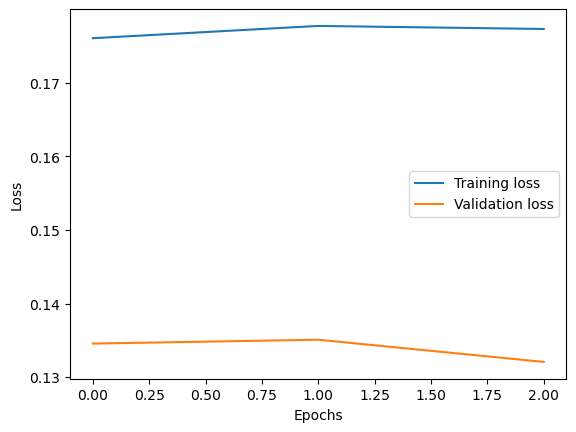

In [17]:
# Plot the learning curves
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [18]:
# Predicting and inverting the normalization
y_pred = scalerY.inverse_transform(model.predict(X_test))
y_test_pl = scalerY.inverse_transform(y_test)

63/63 [==============================] - 0s 590us/step


## Evaluation Metrics

We evaluate the performance of the model using the following metrics:
- **Mean Absolute Error (MAE)**: A measure of the average error between predicted and true redshifts.
- **Residual Analysis**: The difference between spectroscopic redshift (`z_spec`) and predicted redshift (`z_phot`), visualized through histograms and scatter plots.
- **R-squared (R²)**: The proportion of variance in the true redshift values explained by the model's predictions.


In [19]:
# Create a DataFrame with true redshift and predicted redshift
yydf = pd.DataFrame({'Redshift': y_test_pl.flatten(), 'Photo-z': y_pred.flatten()})

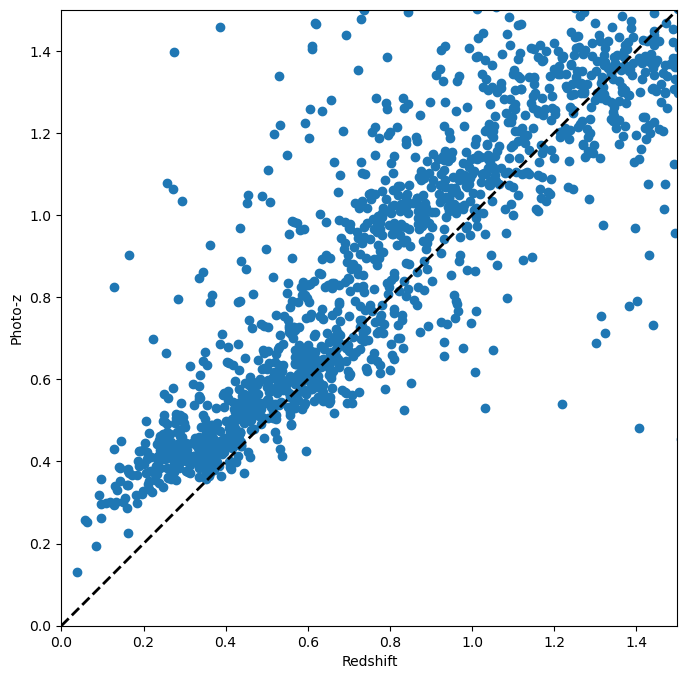

In [20]:
# Scatter plot for Redshift vs Photo-z
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(y_test_pl, y_pred)
ax.set_xlabel('Redshift')
ax.set_ylabel('Photo-z')
ax.plot([0, 2], [0, 2], 'k--', linewidth=2)
ax.set_xlim((0, 1.5))
ax.set_ylim((0, 1.5))
ax.set_aspect('equal')

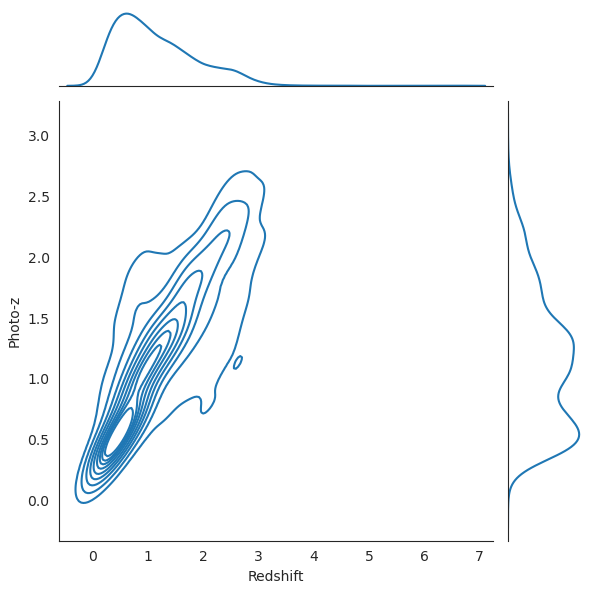

In [21]:
# Use sns.jointplot to visualize the distributions
with sns.axes_style('white'):
    sns.jointplot(x='Redshift', y='Photo-z', data=yydf, kind='kde')

plt.show()

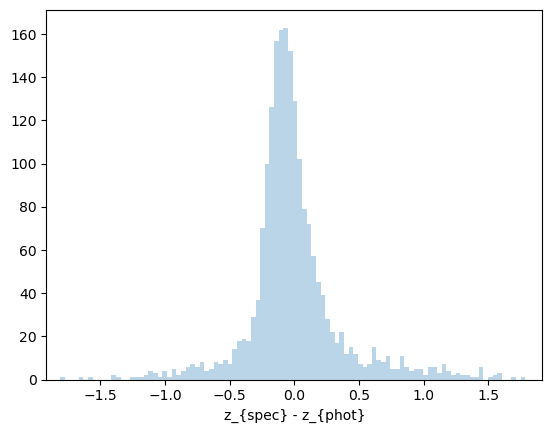

In [22]:
# Histogram of the residuals
sig_pred = np.std(y_test_pl - y_pred)
mean_pred = np.mean(y_test_pl - y_pred)
plt.hist(y_test_pl - y_pred, bins=200, alpha=0.3)
plt.xlim(-4 * sig_pred, 4 * sig_pred)
plt.xlabel('z_{spec} - z_{phot}')
plt.show()

In [23]:
# Display results
print(f"Mean prediction error: {mean_pred}")
print(f"Standard deviation of the error: {sig_pred}")

Mean prediction error: 0.01764153697638678
Standard deviation of the error: 0.4793215664039019


## Conclusion

In this project, we successfully developed a deep learning model capable of estimating photometric redshifts for quasars with reasonable accuracy. By employing modern machine learning techniques such as regularization and cross-validation, we were able to improve the model's performance and generalization.

Future work could involve exploring other architectures, such as convolutional neural networks (CNNs) or transformer models, to further improve performance on photometric data. Additionally, extending the model to include galaxies and stars could make it more versatile for large-scale astronomical surveys.
